In [1]:
from network import Transformer, TransformerModel
import torch
import numpy as np
import matplotlib.pyplot as plt
from torch import nn

In [421]:
def get_cosine_data():
    t_vals = np.linspace(0, 1000, 1000)
    return np.vstack((t_vals, np.cos(1/60 * t_vals) * t_vals / 50)).T

points = get_cosine_data()
points

array([[ 0.00000000e+00,  0.00000000e+00],
       [ 1.00100100e+00,  2.00172340e-02],
       [ 2.00200200e+00,  4.00177531e-02],
       ...,
       [ 9.97997998e+02, -1.20072266e+01],
       [ 9.98998999e+02, -1.17513354e+01],
       [ 1.00000000e+03, -1.14916334e+01]])

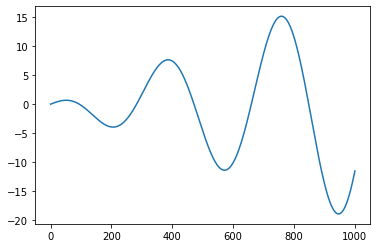

In [422]:
plt.plot(points[:,0], points[:,1])

In [423]:
def get_random_sequence(data, in_seq_len, out_seq_len):
    data_start_index = np.random.randint(0, data.shape[0] - in_seq_len - out_seq_len + 1)
    in_seq, out_seq = data[data_start_index:data_start_index+in_seq_len].copy(), data[data_start_index+in_seq_len-1:data_start_index+in_seq_len+out_seq_len].copy()
    right_most = in_seq[-1].copy()
    in_seq -= right_most
    out_seq -= right_most
    in_seq[:, 0] /= 6
    out_seq[:, 0] /= 6
    in_seq[:, 1] /= 20
    out_seq[:, 1] /= 20
    return in_seq, out_seq[:-1], out_seq[1:]

def get_random_batch(data, in_seq_len, out_seq_len, batch_size):
    in_seq_dat, out_seq_dat, label_seq_dat = [], [], []
    for _ in range(batch_size):
        in_cur, out_cur, label_cur = get_random_sequence(data, in_seq_len, out_seq_len)
        in_seq_dat.append(in_cur)
        out_seq_dat.append(out_cur)
        label_seq_dat.append(label_cur)
    return np.array(in_seq_dat), np.array(out_seq_dat), np.array(label_seq_dat)


In [424]:
get_random_sequence(points.copy(), 4, 6)

(array([[-0.5005005 ,  0.0034338 ],
        [-0.333667  ,  0.00223928],
        [-0.1668335 ,  0.00109439],
        [ 0.        ,  0.        ]]),
 array([[ 0.        ,  0.        ],
        [ 0.1668335 , -0.00104303],
        [ 0.333667  , -0.00203386],
        [ 0.5005005 , -0.00297165],
        [ 0.667334  , -0.00385558],
        [ 0.8341675 , -0.00468486]]),
 array([[ 0.1668335 , -0.00104303],
        [ 0.333667  , -0.00203386],
        [ 0.5005005 , -0.00297165],
        [ 0.667334  , -0.00385558],
        [ 0.8341675 , -0.00468486],
        [ 1.001001  , -0.00545868]]))

In [425]:
batch_in, batch_out, batch_label = get_random_batch(points.copy(), 4, 6, 5)
batch_in, batch_out, batch_label
batch_label

array([[[ 1.66833500e-01,  1.10863782e-03],
        [ 3.33667000e-01,  2.48401768e-03],
        [ 5.00500501e-01,  4.12630776e-03],
        [ 6.67334001e-01,  6.03560046e-03],
        [ 8.34167501e-01,  8.21191227e-03],
        [ 1.00100100e+00,  1.06551836e-02]],

       [[ 1.66833500e-01, -7.97101265e-03],
        [ 3.33667000e-01, -1.59660041e-02],
        [ 5.00500501e-01, -2.39827050e-02],
        [ 6.67334001e-01, -3.20188311e-02],
        [ 8.34167501e-01, -4.00720832e-02],
        [ 1.00100100e+00, -4.81401481e-02]],

       [[ 1.66833500e-01,  4.61249712e-03],
        [ 3.33667000e-01,  9.26156613e-03],
        [ 5.00500501e-01,  1.39459313e-02],
        [ 6.67334001e-01,  1.86642977e-02],
        [ 8.34167501e-01,  2.34153518e-02],
        [ 1.00100100e+00,  2.81977616e-02]],

       [[ 1.66833500e-01, -7.74844063e-03],
        [ 3.33667000e-01, -1.54537871e-02],
        [ 5.00500501e-01, -2.31136054e-02],
        [ 6.67334001e-01, -3.07254663e-02],
        [ 8.34167501e-01, 

In [465]:
device = "cuda" if torch.cuda.is_available() else "cpu"
print(device)
#X, y_in, y_label = get_random_batch(points.copy(), 4, 6, 1)
#X, y_in, y_label = torch.tensor(X).float().to(device), torch.tensor(y_in).float().to(device), torch.tensor(y_label).float().to(device)
#X /= X.std(axis=1)
#y /= y.std(axis=1)
#print(X.std(axis=1))
def train_loop(model, opt, loss_fn, num_batches, batch_size, device):
    """
    Method from "A detailed guide to Pytorch's nn.Transformer() module.", by
    Daniel Melchor: https://medium.com/@danielmelchor/a-detailed-guide-to-pytorchs-nn-transformer-module-c80afbc9ffb1
    """
    model.train()
    total_loss = 0
    
    for _ in range(num_batches):
        #X, y = get_random_batch(points.copy(), 4, 6, batch_size)
        #X, y = torch.tensor(X).float().to(device), torch.tensor(y).float().to(device)
        X, y_in, y_label = get_random_batch(points.copy(), 4, 6, batch_size)
        X, y_in, y_label = torch.tensor(X).float().to(device), torch.tensor(y_in).float().to(device), torch.tensor(y_label).float().to(device)
        
        # Get mask to mask out the next words
        sequence_length = y_in.size(1)
        tgt_mask = model.generate_square_subsequent_mask(sequence_length).to(device).float()

        # Standard training except we pass in y_input and tgt_mask
        pred = model(X, y_in, tgt_mask)
        # Permute pred to have batch size first again
        pred = pred.permute(1, 0, 2) 
        loss = loss_fn(pred, y_label)

        opt.zero_grad()
        loss.backward()
        opt.step()
    
        total_loss += loss.detach().item()
        
    return total_loss / num_batches

def fit(model, opt, loss_fn, num_batches, batch_size, epochs, device):
    """
    Method from "A detailed guide to Pytorch's nn.Transformer() module.", by
    Daniel Melchor: https://medium.com/@danielmelchor/a-detailed-guide-to-pytorchs-nn-transformer-module-c80afbc9ffb1
    """
    
    # Used for plotting later on
    train_loss_list, validation_loss_list = [], []
    
    print("Training and validating model")
    for epoch in range(epochs):
        if epoch % 10 == 9:
            print("-"*25, f"Epoch {epoch + 1}","-"*25)
            
            train_loss = train_loop(model, opt, loss_fn, num_batches, batch_size, device)
            train_loss_list += [train_loss]
            
            print(f"Training loss: {train_loss:.4f}")
            print()
        
    return train_loss_list, validation_loss_list

cuda


In [466]:

model = Transformer(dim_model=16,
                    dim_feature=2,
                    num_heads=8,
                    num_encoder_layers=1,
                    num_decoder_layers=1,
                    dropout_p=0.00).to(device)


#model = TransformerModel(
#    d_model=8,
#    d_encoder_in=2,
#    d_decoder_out=2,
#    nhead=4,
#    d_hid=128,
#    nlayers=6,
#).to(device)

loss_fn = nn.MSELoss()

In [467]:
opt = torch.optim.Adam(model.parameters(), lr=1e-2)
fit(model, opt, loss_fn, 1024, 32, 30, device)

Training and validating model
------------------------- Epoch 10 -------------------------
Training loss: 0.0050

------------------------- Epoch 20 -------------------------
Training loss: 0.0000

------------------------- Epoch 30 -------------------------
Training loss: 0.0000



([0.00496043666705992, 3.363274232981439e-05, 3.347245699925061e-05], [])

In [473]:
X, y_in, y_label = get_random_batch(points.copy(), 4, 6, 1)
X, y_in, y_label = torch.tensor(X).float().to(device), torch.tensor(y_in).float().to(device), torch.tensor(y_label).float().to(device)
X_loc, y_label_loc = X.cpu(), y_label.cpu()
y_loc = y_label_loc.permute(1, 0, 2)
X_loc, y_loc

(tensor([[[-0.5005, -0.0099],
          [-0.3337, -0.0066],
          [-0.1668, -0.0033],
          [ 0.0000,  0.0000]]]),
 tensor([[[0.1668, 0.0034]],
 
         [[0.3337, 0.0069]],
 
         [[0.5005, 0.0104]],
 
         [[0.6673, 0.0140]],
 
         [[0.8342, 0.0176]],
 
         [[1.0010, 0.0213]]]))

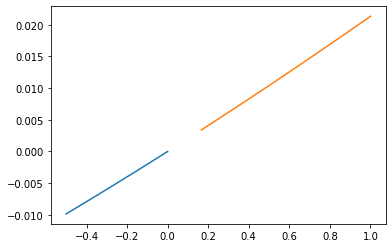

In [474]:
plt.plot(X_loc[0,:,0], X_loc[0,:, 1])
plt.plot(y_loc[:,0,0], y_loc[:,0, 1])

In [475]:
tgt_mask = model.generate_square_subsequent_mask(6).to(device).float()
out = model(X, y_in, tgt_mask)#.permute(1, 0, 2)
out_cpu = out.cpu().detach()
out_cpu

tensor([[[ 0.1678, -0.0044]],

        [[ 0.3349,  0.0023]],

        [[ 0.4999,  0.0080]],

        [[ 0.6683,  0.0129]],

        [[ 0.8345,  0.0168]],

        [[ 1.0021,  0.0215]]])

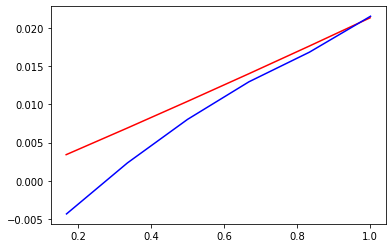

In [476]:
plt.plot(y_loc[:,0,0], y_loc[:,0, 1],color="red")
plt.plot(out_cpu[:,0,0], out_cpu[:,0, 1],color="blue")